# Predicting Ratings Using XGBoost


## Imports

In [69]:
import pandas as pd
import datetime as dt
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import math
from sklearn.metrics import accuracy_score
import numpy as np
import datetime
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure
from sklearn.model_selection import cross_val_score
import sklearn
from sklearn import metrics



## Join Datasets

In [52]:
nf = pd.read_csv('data/For_Navyada_v1.csv')
order_reviews = pd.read_csv('data/olist_order_reviews_dataset.csv')
products = pd.read_csv('data/olist_products_dataset.csv')
nf = nf.merge(products, how='left', on ='product_id')
product_translation = pd.read_csv('data/product_category_name_translation.csv')
nf = nf.merge(product_translation, how='left', on='product_category_name')
nf_new = nf.merge(order_reviews, how='left', on='order_id')
nf = nf_new.iloc[:, :-4]
nf.drop(['customer_unique_id', 'review_id'], axis=1, inplace=True)
nf.dropna(inplace=True)
nf.head()


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_zip_code_prefix,customer_city,...,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,review_score
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,10/2/2017,10/2/2017,10/4/2017,10/10/2017,10/18/2017,3149,sao paulo,...,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,furniture_decor,4
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,7/24/2018,7/26/2018,7/26/2018,8/7/2018,8/13/2018,47813,barreiras,...,perfumaria,29.0,178.0,1.0,400.0,19.0,13.0,19.0,health_beauty,4
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,8/8/2018,8/8/2018,8/8/2018,8/17/2018,9/4/2018,75265,vianopolis,...,automotivo,46.0,232.0,1.0,420.0,24.0,19.0,21.0,auto,5
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,11/18/2017,11/18/2017,11/22/2017,12/2/2017,12/15/2017,59296,sao goncalo do amarante,...,pet_shop,59.0,468.0,3.0,450.0,30.0,10.0,20.0,pet,5
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2/13/2018,2/13/2018,2/14/2018,2/16/2018,2/26/2018,9195,santo andre,...,papelaria,38.0,316.0,4.0,250.0,51.0,15.0,15.0,other,5


## Feature Formating and Extraction 

Added a column called delta delivery: this describes what the difference between actual delivery time and estimated delivery time was 

In [53]:
nf['order_estimated_delivery_date'] = pd.to_datetime(nf['order_estimated_delivery_date'])
nf['order_delivered_customer_date'] = pd.to_datetime(nf['order_delivered_customer_date'])
nf['delta_delivery'] = nf['order_delivered_customer_date'] -  nf['order_estimated_delivery_date']


In [59]:
nf['delta_delivery'] = nf['delta_delivery'].dt.days.astype('int16')


In [60]:
nf.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_zip_code_prefix,customer_city,...,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,review_score,delta_delivery
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,10/2/2017,10/2/2017,10/4/2017,2017-10-10,2017-10-18,3149,sao paulo,...,40.0,268.0,4.0,500.0,19.0,8.0,13.0,furniture_decor,4,-8
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,7/24/2018,7/26/2018,7/26/2018,2018-08-07,2018-08-13,47813,barreiras,...,29.0,178.0,1.0,400.0,19.0,13.0,19.0,health_beauty,4,-6
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,8/8/2018,8/8/2018,8/8/2018,2018-08-17,2018-09-04,75265,vianopolis,...,46.0,232.0,1.0,420.0,24.0,19.0,21.0,auto,5,-18
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,11/18/2017,11/18/2017,11/22/2017,2017-12-02,2017-12-15,59296,sao goncalo do amarante,...,59.0,468.0,3.0,450.0,30.0,10.0,20.0,pet,5,-13
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2/13/2018,2/13/2018,2/14/2018,2018-02-16,2018-02-26,9195,santo andre,...,38.0,316.0,4.0,250.0,51.0,15.0,15.0,other,5,-10


## Data Exploration and Descriptive Statistics 

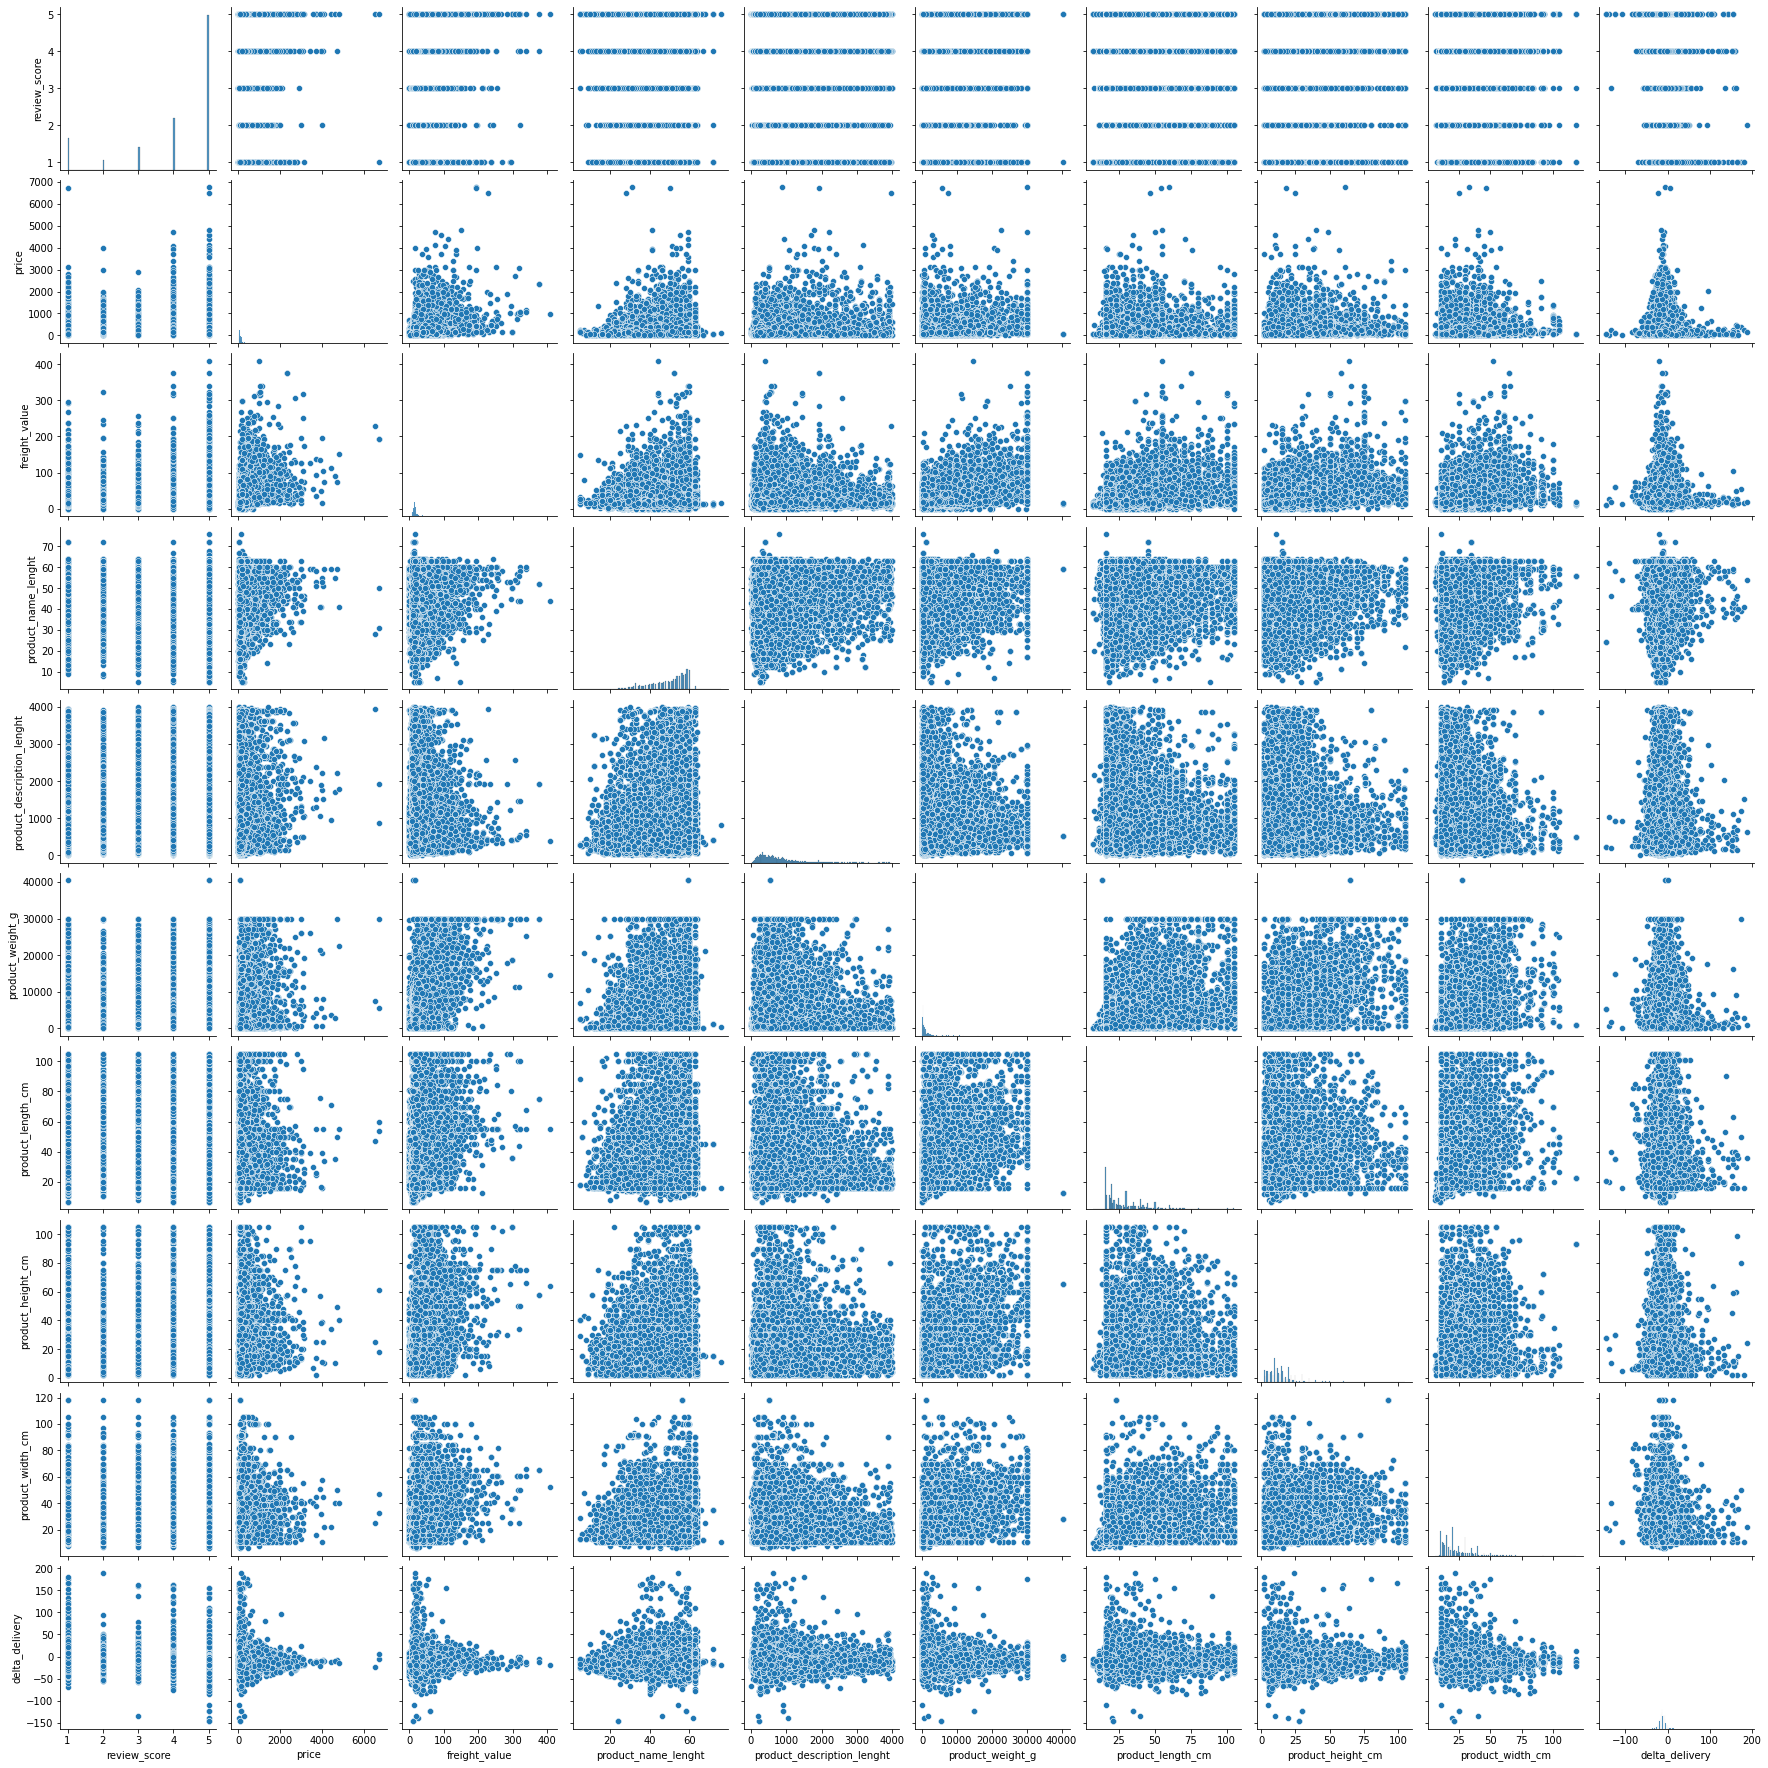

In [90]:
pair = nf.loc[:, ['review_score','price', 'freight_value', 'product_name_lenght', 'product_description_lenght', 'product_weight_g', 'product_length_cm', 'product_height_cm','product_width_cm', 'delta_delivery']]
sns.pairplot(pair)

Text(0.5, 1.0, 'Product Description Length')

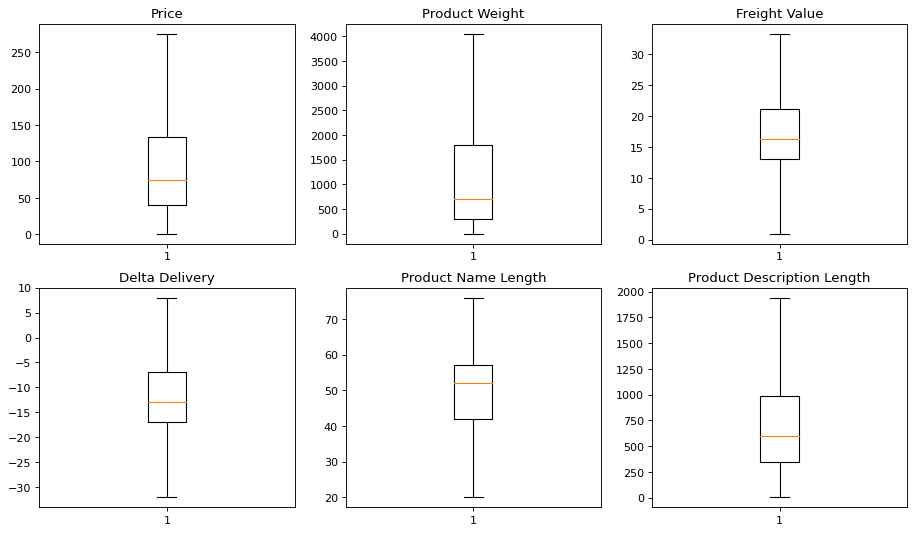

In [77]:
fig, axs = plt.subplots(2, 3, figsize=(14, 8), dpi=80)
axs[0, 0].boxplot(nf['price'], showfliers=False)
axs[0, 0].set_title('Price')
axs[0, 1].boxplot(nf['product_weight_g'], showfliers=False)
axs[0, 1].set_title('Product Weight')
axs[0, 2].boxplot(nf['freight_value'], showfliers=False)
axs[0, 2].set_title('Freight Value')
axs[1, 0].boxplot(nf['delta_delivery'], showfliers=False)
axs[1, 0].set_title('Delta Delivery')
axs[1, 1].boxplot(nf['product_name_lenght'], showfliers=False)
axs[1, 1].set_title('Product Name Length')
axs[1, 2].boxplot(nf['product_description_lenght'], showfliers=False)
axs[1, 2].set_title('Product Description Length')

Text(0.5, 1.0, 'Category Distribution')

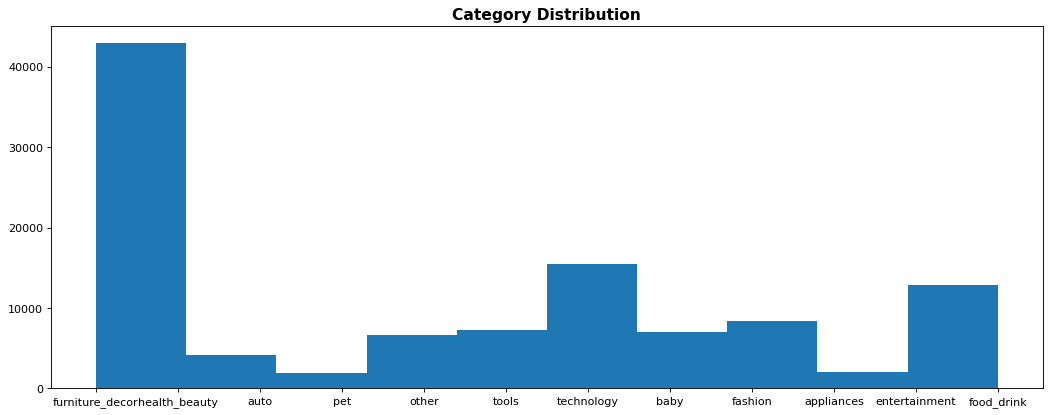

In [76]:
figure(figsize=(16, 6), dpi=80)
plt.hist(nf['product_category_name_english'], align='mid')
plt.title('Category Distribution', weight='bold', fontsize=14)

Text(0.5, 1.0, 'Customer State')

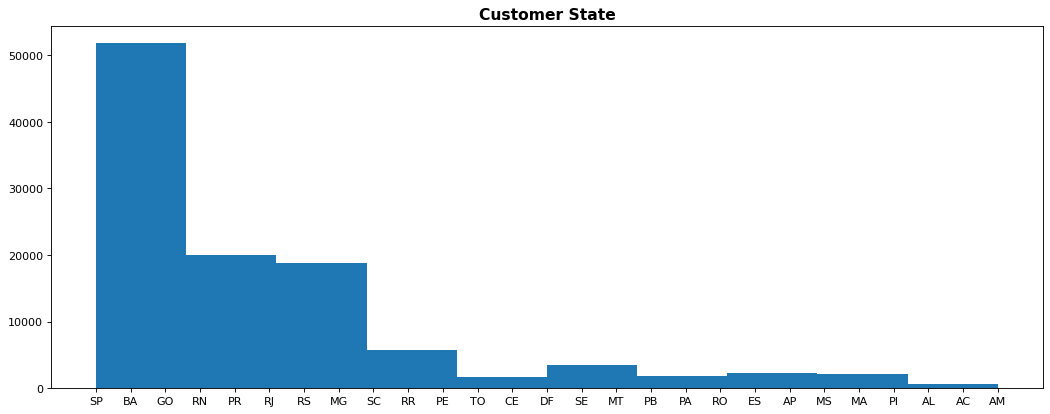

In [80]:
figure(figsize=(16, 6), dpi=80)
plt.hist(nf['customer_state'], align='mid')
plt.title('Customer State', weight='bold', fontsize=14)

Text(0.5, 1.0, 'Review Score')

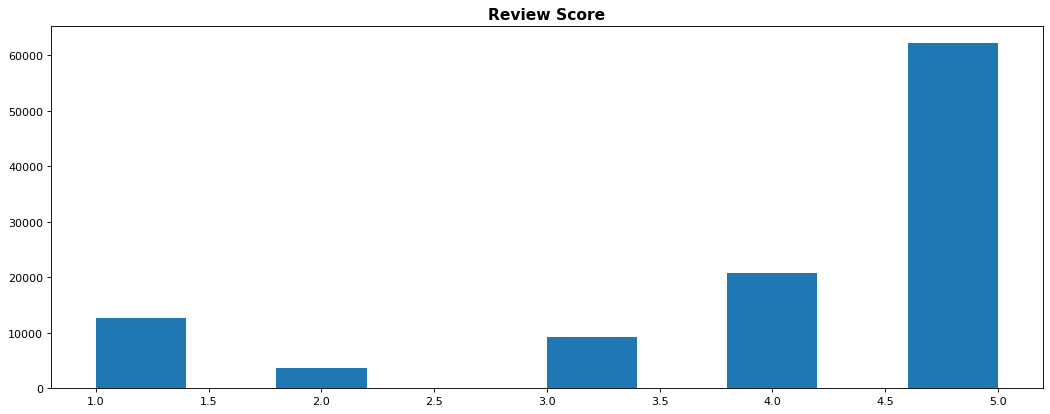

In [157]:
figure(figsize=(16, 6), dpi=80)
plt.hist(nf['review_score'], align='mid')
plt.title('Review Score', weight='bold', fontsize=14)

In [79]:
nf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 108649 entries, 0 to 113687
Data columns (total 43 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       108649 non-null  object        
 1   customer_id                    108649 non-null  object        
 2   order_status                   108649 non-null  object        
 3   order_purchase_timestamp       108649 non-null  object        
 4   order_approved_at              108649 non-null  object        
 5   order_delivered_carrier_date   108649 non-null  object        
 6   order_delivered_customer_date  108649 non-null  datetime64[ns]
 7   order_estimated_delivery_date  108649 non-null  datetime64[ns]
 8   customer_zip_code_prefix       108649 non-null  int64         
 9   customer_city                  108649 non-null  object        
 10  customer_state                 108649 non-null  object        
 11  

In [91]:
nf.describe(include='all') 

<ipython-input-91-7892632c959a>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  nf.describe(include='all')
<ipython-input-91-7892632c959a>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  nf.describe(include='all')


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_zip_code_prefix,customer_city,...,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,review_score,delta_delivery
count,108649,108649,108649,108649,108649,108649,108649,108649,108649.000000,108649,...,108649.000000,108649.000000,108649.000000,108649.000000,108649.000000,108649.000000,108649.000000,108649,108649.000000,108649.000000
unique,94580,94580,2,602,597,511,604,420,NaN,4027,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12,NaN,NaN
top,5a3b1c29a49756e75f1ef513383c0c12,be1c4e52bb71e0c54b11a26b8e8d59f2,delivered,11/24/2017,4/24/2018,11/28/2017,2018-05-14 00:00:00,2017-12-20 00:00:00,NaN,sao paulo,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,furniture_decor,NaN,NaN
freq,22,22,108648,1344,1098,866,514,598,NaN,17199,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30165,NaN,NaN
first,NaN,NaN,NaN,NaN,NaN,NaN,2017-01-11 00:00:00,2017-02-01 00:00:00,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,2018-10-17 00:00:00,2018-10-25 00:00:00,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35061.276128,NaN,...,48.807822,786.320859,2.206868,2094.255686,30.206426,16.573793,23.038123,NaN,4.068542,-11.974956
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29879.034366,NaN,...,10.004414,651.153145,1.718994,3744.096736,16.153517,13.429203,11.699429,NaN,1.357098,10.051762
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1003.000000,NaN,...,5.000000,4.000000,1.000000,0.000000,7.000000,2.000000,6.000000,NaN,1.000000,-147.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11090.000000,NaN,...,42.000000,347.000000,1.000000,300.000000,18.000000,8.000000,15.000000,NaN,4.000000,-17.000000


## XGBoost to Predict Ratings

In [94]:
Xy = nf.loc[:,['order_status', 'delta_delivery','order_purchase_month_name','order_purchase_hour','price','freight_value','nome_regiao','payment_type', 'payment_value','payment_installments','review_score']].copy()
Xy.dropna(inplace=True)
Xy = pd.get_dummies(Xy)

In [96]:
X = Xy.drop('review_score', axis=1)
y = Xy['review_score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
xgb = XGBRegressor(enable_categorical=True)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = math.sqrt(mse)
print('RMSE:', rmse)

[16:24:28] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { enable_categorical } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


RMSE: 1.1787166023141098


In [118]:
rmses = []
depths = [0, 1, 3, 6, 7, 10]
for depth in depths:
    xgb_reg = XGBRegressor(max_depth=depth, enable_categorical=True, eval_metric=mean_squared_error)
    scores = cross_val_score(xgb_reg, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
    rmses.append(scores.mean())

[17:19:21] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { enable_categorical } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:19:26] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { enable_categorical } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:19:31] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost

In [121]:
rmses = [-x for x in rmses]

Text(0.5, 1.0, 'RMSE vs Max_Depth Parameter for XGBoost')

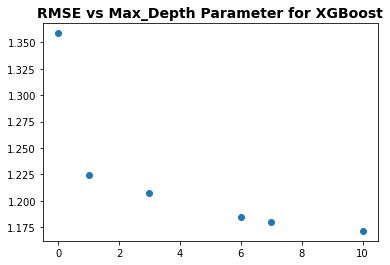

In [122]:
plt.scatter(depths, rmses)
plt.title('RMSE vs Max_Depth Parameter for XGBoost', weight='bold', fontsize=14)

In [147]:
rmses

[1.3585062941321282,
 1.224518614281869,
 1.2070887138506081,
 1.18464153622728,
 1.1801778433677808,
 1.1715824439391864]

Max depth of 10 performed the best with an RMSE of 1.172

In [126]:
xgb_reg = XGBRegressor(max_depth=10, enable_categorical=True, eval_metric=mean_squared_error)
xgb_reg.fit(X_train, y_train)

[17:28:31] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { enable_categorical } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=True,
             eval_metric=<function mean_squared_error at 0x7fb68dece3a0>,
             gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=10, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=4,
             num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

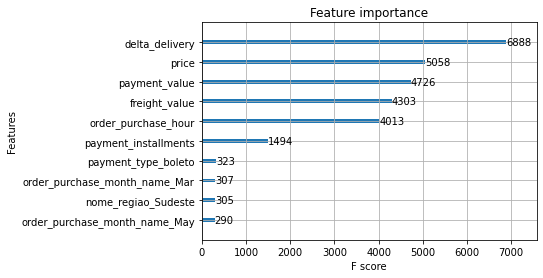

In [128]:
from xgboost import plot_importance
plot_importance(xgb_reg, max_num_features=10)

## Use Case 

The following shows an example of how the model could be used by a Brazilian Ecommerce Marketing and Sales Team. 
If they have a product that is normally $20 that they want to put on sale to boost their ratings, they could input their product's parameters and predict the ratings the product will receive at each price point to maximize ratings. 

In [158]:
#simulating an input and trying various prices (all other parameters hold the same)
use_case = X_test.iloc[0:1, :].copy()
use_case = pd.concat([use_case]*6)
test_price = [15, 16, 17, 18, 19, 20]
use_case['price'] = test_price

In [159]:
predictions = xgb_reg.predict(use_case)

Text(0, 0.5, 'Rating')

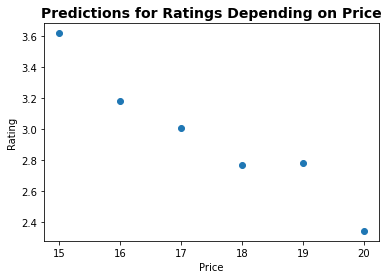

In [160]:
plt.scatter(test_price, predictions)
plt.title('Predictions for Ratings Depending on Price', weight='bold', fontsize=14)
plt.xlabel('Price')
plt.ylabel('Rating')

The sales team could choose to price their products at $15 instead of $20 in order to improve their ratings by over 1 point. Reducing the price even $1-2 increases the rating by .2 points. 